<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2022notebooks/2022_1024CNN_layer_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 畳み込みニューラルネットワークの事前訓練済モデルの中間表現を可視化する

- filename: `2022_1024CNN_layer_visualizaton.ipynb`
- author: 浅川伸一
- License: MIT
- date: 2022_1024



In [1]:
%config InlineBackend.figure_format = 'retina'
try:
    import bit
except ImportError:
    !pip install ipynbname --upgrade > /dev/null 2>&1
    !git clone https://github.com/ShinAsakawa/bit.git
    import bit

isColab = bit.isColab
HOME = bit.HOME

Cloning into 'bit'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 322
Receiving objects: 100% (325/325), 6.04 MiB | 25.55 MiB/s, done.
Resolving deltas: 100% (240/240), done.
日付: 2022-10-27
HOSTNAME: 2ca78ee83e20
ユーザ名: root
HOME: /root
ファイル名: /fileId=https%3A%2F%2Fgithub.com%2FShinAsakawa%2FShinAsakawa.github.io%2Fblob%2Fmaster%2F2022notebooks%2F2022_1024CNN_layer_visualization.ipynb
torch.__version__: 1.12.1+cu113
url:https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifJP.zip
NotoSerifJP.zip をダウンロード中 36145566 バイト
url:https://noto-website-2.storage.googleapis.com/pkgs/NotoSansJP.zip
NotoSansJP.zip をダウンロード中 26466579 バイト


In [3]:
import torch
import torchvision
from torchvision import models, transforms
from termcolor import colored

from IPython.display import clear_output

# torchviz のインストール
try:
    import torchviz
except ImportError:
    !pip install torchviz
    import torchviz

# torchsummary のインストール    
try:
    import torchsummary
except ImportError:
    !pip install torchsummary
    import torchsummary    
    
try:    
    import japanize_matplotlib    
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib
    
clear_output()    

In [4]:
# 各モデルを定義し，訓練済み結合係数をダウンロード
DNNs = {}
DNNs['resnet18'] = models.resnet18(weights='DEFAULT', progress=True)
DNNs['alexnet'] = models.alexnet(weights='DEFAULT', progress=True)
DNNs['vgg16'] = models.vgg16(weights='DEFAULT', progress=True)
DNNs['squeezenet']= models.squeezenet1_0(weights='DEFAULT', progress=True)
DNNs['densenet'] = models.densenet161(weights='DEFAULT', progress=True)
DNNs['inception'] = models.inception_v3(weights='DEFAULT', progress=True)
DNNs['googlenet'] = models.googlenet(weights='DEFAULT', progress=True)
DNNs['shufflenet'] = models.shufflenet_v2_x1_0(weights='DEFAULT', progress=True)
DNNs['mobilenet'] = models.mobilenet_v2(weights='DEFAULT', progress=True)
# DNNs['resnext50_32x4d'] = models.resnext50_32x4d(weights='DEFAULT', progress=True)
# DNNs['wide_resnet50_2'] = models.wide_resnet50_2(weights='DEFAULT', progress=True)
#DNNs['mnasnet'] = models.mnasnet1_0(weights='DEFAULT', progress=True)

# 上の中から試したいモデルを選んでください。最後のモデルが有効になります。
net = DNNs['resnet18'] 
# net = DNNs['alexnet']
# net = DNNs['squeezenet']
# net = DNNs['googlenet']
#net = DNNs['shufflenet']
# net = DNNs['mobilenet']
#net = DNNs['vgg16']
#net = DNNs['inception']
clear_output()

In [5]:
import torchsummary
torchsummary.summary(net,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

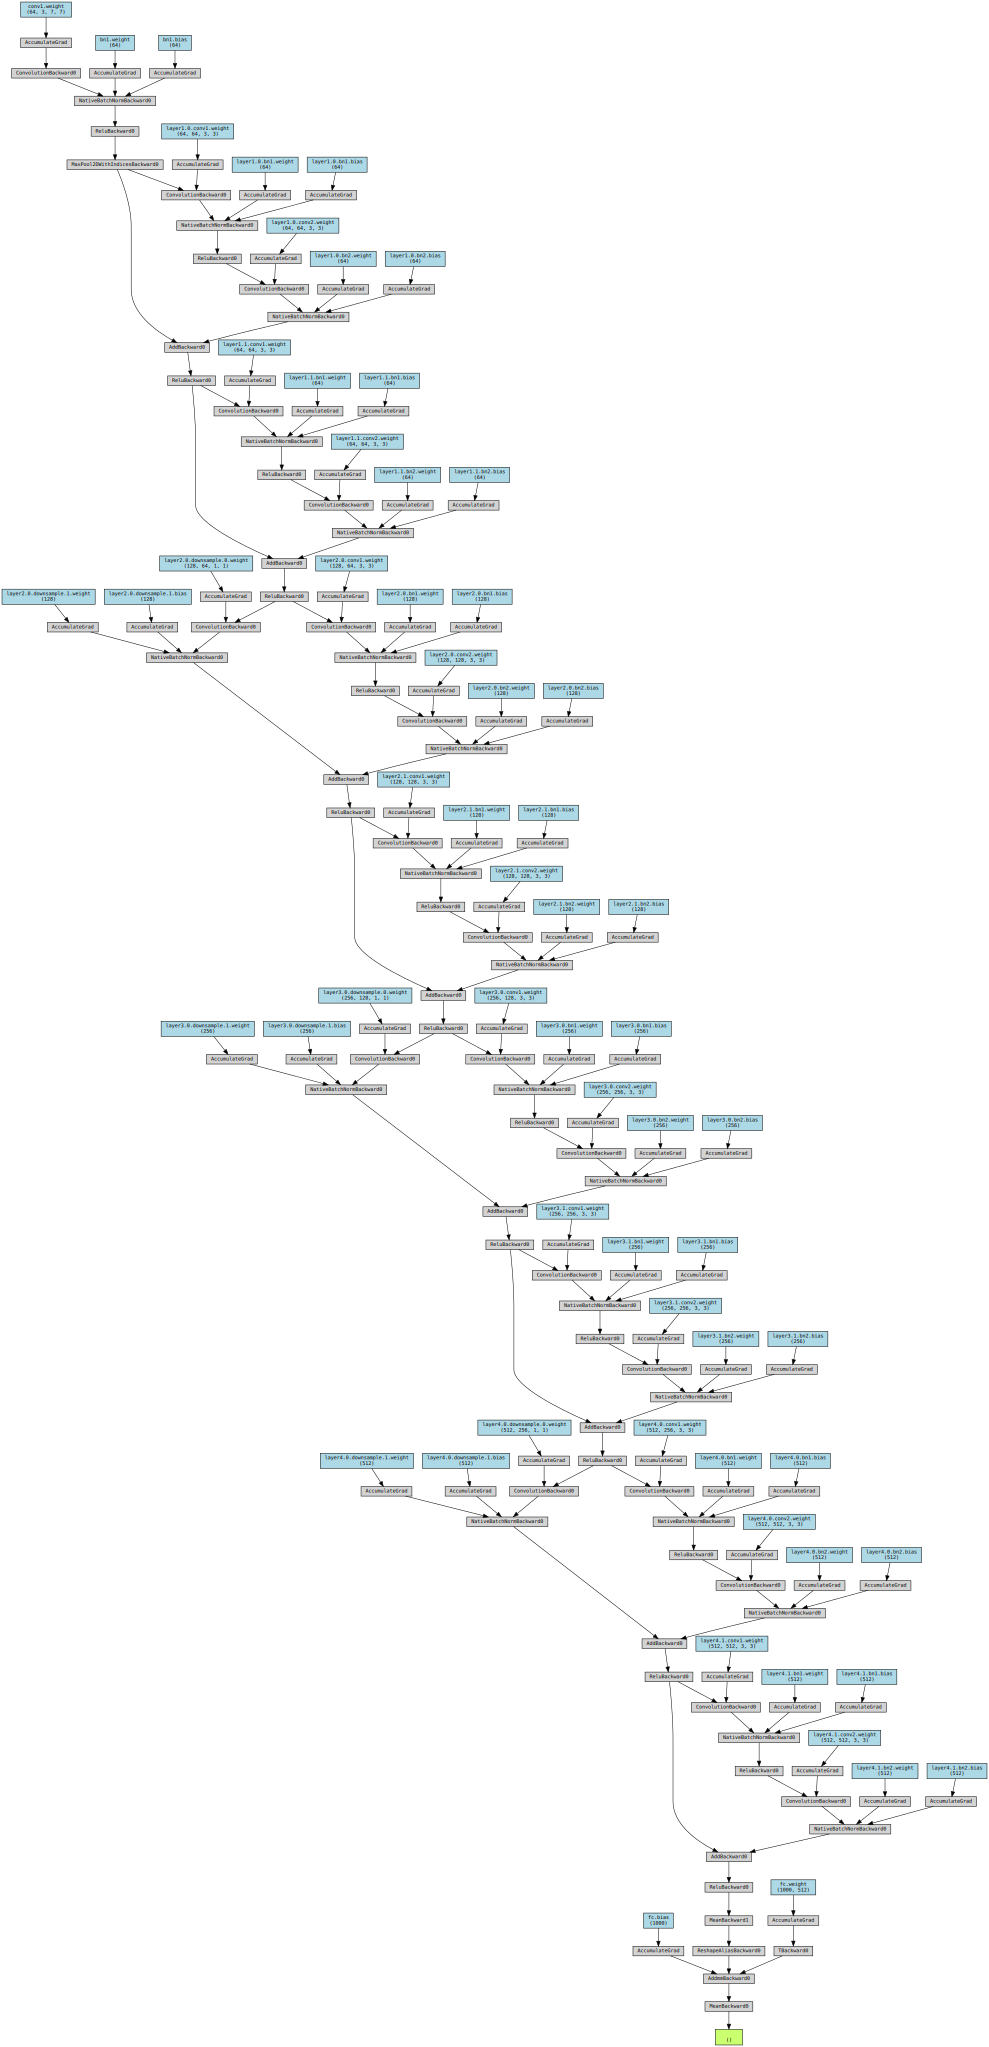

In [6]:
from torchviz import make_dot
x = torch.rand([1,3,224,224])
y = net.forward(x)
make_dot(y.mean(), params=dict(net.named_parameters()))    

In [9]:
for module_name in net.named_modules():
    if not '.' in module_name[0] and '' != module_name[0]:
        print(f'モジュール名: {module_name[0]}')

モジュール名: conv1
モジュール名: bn1
モジュール名: relu
モジュール名: maxpool
モジュール名: layer1
モジュール名: layer2
モジュール名: layer3
モジュール名: layer4
モジュール名: avgpool
モジュール名: fc


In [10]:
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)

    def clear(self):
        self.outputs = []

saved_output = SaveOutput()
hook_handles = []

# hooked_modules の内容を上で表示されたモジュールの中から選ぶ必要があります
hooked_modules = ['conv1', 'relu', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
#hooked_modules = ['features', 'avgpool']
#hooked_modules = ['maxpool2', 'maxpool3', 'maxpool4', 'avgpool']
#hooked_modules = ['features.2', 'features.8', 'features.18']
#hookd_modules = ['conv1', 'maxpool', 'stage2', 'stage3', 'stage4', 'conv5']
#hookd_modules = ['conv1', 'conv5']
for _module in net.named_modules():
    if _module[0] in hooked_modules:
        print(f'{_module[0]} hooked {type(_module[1])}')
        handle = _module[1].register_forward_hook(saved_output)
        hook_handles.append(handle)
    
saved_output.clear()

conv1 hooked <class 'torch.nn.modules.conv.Conv2d'>
relu hooked <class 'torch.nn.modules.activation.ReLU'>
layer1 hooked <class 'torch.nn.modules.container.Sequential'>
layer2 hooked <class 'torch.nn.modules.container.Sequential'>
layer3 hooked <class 'torch.nn.modules.container.Sequential'>
layer4 hooked <class 'torch.nn.modules.container.Sequential'>
avgpool hooked <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>


In [11]:
# サンプル画像を持ってくる
!wget -O cat.jpg https://www.cats.org.uk/media/6189/manja-vitolic-gkxkby-c-dk-unsplash-web.jpg
clear_output()

In [ ]:
from PIL import Image
from torchvision import transforms as T
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
image = Image.open('cat.jpg')
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

net.eval()
out = net(X)
len(saved_output.outputs)

In [ ]:
# モジュールの表示
plt.figure(figsize=(12,4))
for i in range(len(saved_output.outputs)):
    plt.subplot(1,len(saved_output.outputs),i+1)
    plt.gca().set_title(f'{hooked_modules[i]}')
    plt.imshow(saved_output.outputs[i].detach().numpy().mean(axis=1)[0], cmap='gray')

plt.show() 